# Regression

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [165]:
from sklearn import datasets, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

df = pd.read_csv('./diabetes.csv')

In [3]:
del df['Unnamed: 0']

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,change,readmitted
0,72091308,20123568,Caucasian,Female,75,NaN,1,22,7,58,2,15,injury and poisoning,"endocrine, nutritional and metabolic diseases,...",diseases of the blood and blood-forming organs,9,Ch,NO
1,72848634,20377854,Caucasian,Female,65,NaN,2,1,3,59,3,11,external causes of injury and supplemental cla...,diseases of the circulatory system,diseases of the genitourinary system,6,No,NO
2,73062156,20408121,Caucasian,Female,95,NaN,1,1,4,56,1,9,diseases of the digestive system,diseases of the circulatory system,diseases of the digestive system,6,No,NO
3,73731852,20542797,Caucasian,Male,75,NaN,1,2,10,68,1,18,diseases of the skin and subcutaneous tissue,diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,...",6,Ch,NO
4,80820942,20514150,Caucasian,Female,65,NaN,2,1,4,33,0,11,diabetes-related,diseases of the circulatory system,diseases of the circulatory system,4,Ch,<30


In [5]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                          int64
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
change                      object
readmitted                  object
dtype: object

The `readmitted` column currently contains three categorical values for whether a patient is readmitted. We'll simplify the values in the column and designate 0 to mean not readmitted and 1 to signify readmitted.

In [6]:
df['readmitted'].replace({'NO':0, '>30':1, '<30':1}, inplace=True)
df['readmitted'].value_counts()

0    31019
1     8706
Name: readmitted, dtype: int64

Let's also look at a heatmap to get an idea of which features are more closely correlated in order to choose predictor variables for our model.

<AxesSubplot:>

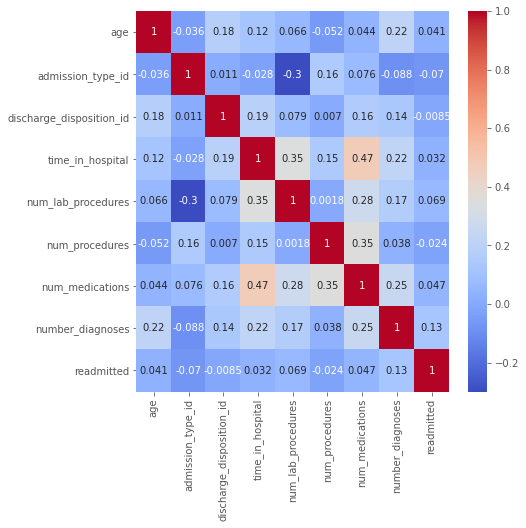

In [78]:
df1 = df[['age', 'admission_type_id', 'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'readmitted']]

plt.figure(figsize=(7, 7))
sns.heatmap(df1.corr(), cmap='coolwarm', annot=True)

### Variable Pre-Processing

We'll pre-process data using the following steps:
1. Split the data into train, test, and validation sets.
2. One-hot encode categorical variables for each set.
3. Standardize continous variables for each set.
4. Combine the processed features into a dataframe.

In [8]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, label_train, label_test = train_test_split(df[['race', 'gender', 'age',
                                                                'admission_type_id', 'discharge_disposition_id', 'time_in_hospital',
                                                                'num_procedures', 'num_medications', 'diag_1']], df['readmitted'],
                                                            test_size=0.2, random_state=2018)
X_train, X_val, label_train, label_val = train_test_split(df[['race', 'gender', 'age',
                                                                'admission_type_id', 'discharge_disposition_id', 'time_in_hospital',
                                                                'num_procedures', 'num_medications', 'diag_1']], df['readmitted'],
                                                            test_size=0.25, random_state=2019)

In [9]:
# Select categorical variables from training set
cat_variable = ['race', 'gender', 'diag_1']

X_train_cat = X_train[cat_variable]

In [10]:
# Instantiate OneHotEncoder object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [11]:
# Create categorial dataframe with column names
columns = ohe.get_feature_names(cat_variable)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_1_diseases of the nervous system and sense organs,diag_1_diseases of the respiratory system,diag_1_diseases of the skin and subcutaneous tissue,"diag_1_endocrine, nutritional and metabolic diseases, and immunity disorders",diag_1_external causes of injury and supplemental classification,diag_1_infectious and parasitic diseases,diag_1_injury and poisoning,diag_1_mental disorders,diag_1_neoplasms,"diag_1_symptoms, signs, and ill-defined conditions"
32808,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17840,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20047,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31796,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8831,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Repeat for test set
X_test_cat = X_test[['race', 'gender', 'diag_1']]

cats_test = ohe.transform(X_test_cat)

cat_columns = ohe.get_feature_names(['race', 'gender', 'diag_1'])
X_test_cat_df = pd.DataFrame(cats_test, columns=cat_columns, index=X_test_cat.index)
X_test_cat_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_1_diseases of the nervous system and sense organs,diag_1_diseases of the respiratory system,diag_1_diseases of the skin and subcutaneous tissue,"diag_1_endocrine, nutritional and metabolic diseases, and immunity disorders",diag_1_external causes of injury and supplemental classification,diag_1_infectious and parasitic diseases,diag_1_injury and poisoning,diag_1_mental disorders,diag_1_neoplasms,"diag_1_symptoms, signs, and ill-defined conditions"
12251,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
294,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
# Repeat for validation set
X_val_cat = X_val[['race', 'gender', 'diag_1']]

cats_val = ohe.transform(X_val_cat)

cat_columns = ohe.get_feature_names(['race', 'gender', 'diag_1'])
X_val_cat_df = pd.DataFrame(cats_val, columns=cat_columns, index=X_val_cat.index)
X_val_cat_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_1_diseases of the nervous system and sense organs,diag_1_diseases of the respiratory system,diag_1_diseases of the skin and subcutaneous tissue,"diag_1_endocrine, nutritional and metabolic diseases, and immunity disorders",diag_1_external causes of injury and supplemental classification,diag_1_infectious and parasitic diseases,diag_1_injury and poisoning,diag_1_mental disorders,diag_1_neoplasms,"diag_1_symptoms, signs, and ill-defined conditions"
25681,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12392,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Pre-process continous variables
X_train_cont = X_train[['age', 'admission_type_id', 'discharge_disposition_id',
                        'time_in_hospital', 'num_procedures', 'num_medications']]

X_train_cont.head()

,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
32808,75,1,1,1,0,12
17840,75,2,1,1,6,15
20047,85,1,3,2,2,13
31796,35,1,1,1,0,10
8831,85,2,11,3,1,3


In [15]:
# Standardize continous variable
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
32808,0.524942,-0.741534,-0.491223,-1.103291,-0.774528,-0.498613
17840,0.524942,0.176692,-0.491223,-1.103291,2.760324,-0.126908
20047,1.167596,-0.741534,-0.007445,-0.758083,0.403756,-0.374711
31796,-2.045670,-0.741534,-0.491223,-1.103291,-0.774528,-0.746416
8831,1.167596,0.176692,1.927666,-0.412875,-0.185386,-1.613727


In [16]:
# Repeat for test set
X_test_cont = X_test[['age', 'admission_type_id', 'discharge_disposition_id',
                        'time_in_hospital', 'num_procedures', 'num_medications']]

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
12251,-0.760364,-0.741534,1.927666,-1.103291,0.403756,-0.126908
294,1.167596,-0.741534,-0.491223,-0.412875,-0.185386,-0.994219
27846,1.167596,1.094918,-0.007445,3.039204,-0.774528,-0.003007
24932,-0.117711,0.176692,-0.007445,0.622749,0.403756,0.120895
12493,-0.117711,-0.741534,-0.249334,-1.103291,-0.774528,-0.994219


In [17]:
# Repeat for validation set
X_val_cont = X_val[['age', 'admission_type_id', 'discharge_disposition_id',
                        'time_in_hospital', 'num_procedures', 'num_medications']]

X_val_scaled = ss.transform(X_val_cont)

cont_columns = X_val_cont.columns
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=cont_columns, index=X_val_cont.index)

X_val_scaled_df.head()

,age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
25681,0.524942,-0.741534,-0.007445,-0.067667,0.403756,0.120895
10685,1.167596,-0.741534,-0.007445,-0.412875,-0.185386,-0.250810
12392,0.524942,1.094918,1.927666,-0.067667,-0.185386,0.492599
23686,-0.760364,-0.741534,-0.007445,0.277541,-0.185386,0.864304
39038,0.524942,-0.741534,-0.491223,-0.758083,2.760324,0.492599


In [18]:
# Combine continous and categorical features for train set
X_train_combined = pd.concat([X_train_cat_df, X_train_scaled_df], axis='columns')

X_train_combined.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_1_injury and poisoning,diag_1_mental disorders,diag_1_neoplasms,"diag_1_symptoms, signs, and ill-defined conditions",age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
32808,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.524942,-0.741534,-0.491223,-1.103291,-0.774528,-0.498613
17840,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.524942,0.176692,-0.491223,-1.103291,2.760324,-0.126908
20047,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.167596,-0.741534,-0.007445,-0.758083,0.403756,-0.374711
31796,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-2.045670,-0.741534,-0.491223,-1.103291,-0.774528,-0.746416
8831,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.167596,0.176692,1.927666,-0.412875,-0.185386,-1.613727


In [19]:
# Repeat for test set
X_test_combined = pd.concat([X_test_cat_df, X_test_scaled_df], axis='columns')

X_test_combined.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_1_injury and poisoning,diag_1_mental disorders,diag_1_neoplasms,"diag_1_symptoms, signs, and ill-defined conditions",age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
12251,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.760364,-0.741534,1.927666,-1.103291,0.403756,-0.126908
294,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.167596,-0.741534,-0.491223,-0.412875,-0.185386,-0.994219
27846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.167596,1.094918,-0.007445,3.039204,-0.774528,-0.003007
24932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.117711,0.176692,-0.007445,0.622749,0.403756,0.120895
12493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.117711,-0.741534,-0.249334,-1.103291,-0.774528,-0.994219


In [20]:
# Repeat for validation set
X_val_combined = pd.concat([X_val_cat_df, X_val_scaled_df], axis='columns')

X_val_combined.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_1_injury and poisoning,diag_1_mental disorders,diag_1_neoplasms,"diag_1_symptoms, signs, and ill-defined conditions",age,admission_type_id,discharge_disposition_id,time_in_hospital,num_procedures,num_medications
25681,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.524942,-0.741534,-0.007445,-0.067667,0.403756,0.120895
10685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.167596,-0.741534,-0.007445,-0.412875,-0.185386,-0.250810
12392,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.524942,1.094918,1.927666,-0.067667,-0.185386,0.492599
23686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.760364,-0.741534,-0.007445,0.277541,-0.185386,0.864304
39038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.524942,-0.741534,-0.491223,-0.758083,2.760324,0.492599


### KNN and Logistic Regression
Let's now fit our data to KNN and Logistic Regression models and look at accuracy, precision, and recall scores for each.

In [123]:
def print_accuracy(model, x_tr, y_tr, x_te, y_te):
    print("The accuracy score for {} is...".format(model))
    print("Training: {:6.2f}%".format(100*model.score(x_tr, y_tr)))
    print("Test set: {:6.2f}%".format(100*model.score(x_te, y_te)))

In [124]:
def precision_and_recall(y_te, y_pred, threshold=0.5):
    if threshold != 0.5:
        print("Threshold of {}...".format(threshold))
    else:
        print("Default threshold...")
    print("Precision: {:6.2f}%, Recall: {:6.2f}%".format(100*precision_score(y_te, y_pred),
                                                      100*recall_score(y_te, y_pred)))

In [125]:
def print_scores(model, x_tr, y_tr, x_te, y_te, y_pred, threshold=0.5):
    '''
    This function prints accuracy, precision, and recall scores for a given model
    '''
    
    print("The accuracy score for {} is...".format(model))
    print("Training: {:6.2f}%".format(100*model.score(x_tr, y_tr)))
    print("Test set: {:6.2f}%".format(100*model.score(x_te, y_te)))
    
    if threshold != 0.5:
        print("Threshold of {}...".format(threshold))
    else:
        print("Default threshold...")
    print("Precision: {:6.2f}%, Recall: {:6.2f}%".format(100*precision_score(y_te, y_pred),
                                                      100*recall_score(y_te, y_pred)))

In [126]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_combined, label_train)

print_accuracy(knn, X_train_combined, label_train, X_test_combined, label_test)

The accuracy score for KNeighborsClassifier() is...
Training:  80.75%
Test set:  79.46%


In [129]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = knn.predict(X_test_combined)
    
precision_and_recall(label_test, y_predict)

Default threshold...
Precision:  57.58%, Recall:  22.97%


In [130]:
# using the new threshold of 0.06
y_predict = (knn.predict_proba(X_test_combined)[:,1] > 0.06)

precision_and_recall(label_test, y_predict, 0.06)

Threshold of 0.06...
Precision:  30.44%, Recall:  93.78%


Let's now look at the same information for the logistic regression model to compare.

In [83]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train_combined, label_train)
print("The accuracy score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train_combined, label_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test_combined, label_test)))

The accuracy score for logistic regression is
Training:  77.95%
Test set:  78.14%


/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logit.predict(X_test_combined)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(label_test, y_predict), 
                                                     recall_score(label_test, y_predict)))

Default threshold:
Precision: 0.0000,   Recall: 0.0000


/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# using the new threshold of 0.06
y_predict = (logit.predict_proba(X_test_combined)[:,1] > 0.06)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(label_test, y_predict), 
                                                     recall_score(label_test, y_predict)))

Threshold of 0.06:
Precision: 0.2186,   Recall: 1.0000


Let's do a prediction using our Linear Regression model. We can see that the logistic regression model predicts an outcome of 0, or not readmitted, roughly 80% of the time and an outcome of 1, or readmitted, about 20% of the time.

In [23]:
prediction = logit.predict_proba(X_test_combined)
prediction

array([[0.78733252, 0.21266748],
       [0.80630192, 0.19369808],
       [0.80123409, 0.19876591],
       ...,
       [0.75062451, 0.24937549],
       [0.79380163, 0.20619837],
       [0.79479739, 0.20520261]])

We'll also look at the confusion matrices for each model.

In [24]:
from sklearn.metrics import confusion_matrix

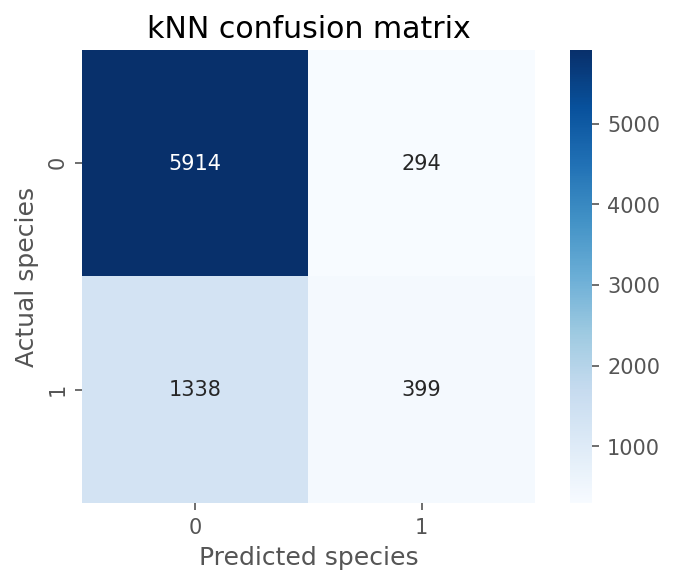

In [25]:
# Print confusion matrix for kNN
knn_confusion = confusion_matrix(label_test, knn.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=df['readmitted'].unique(),
           yticklabels=df['readmitted'].unique())

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('kNN confusion matrix');

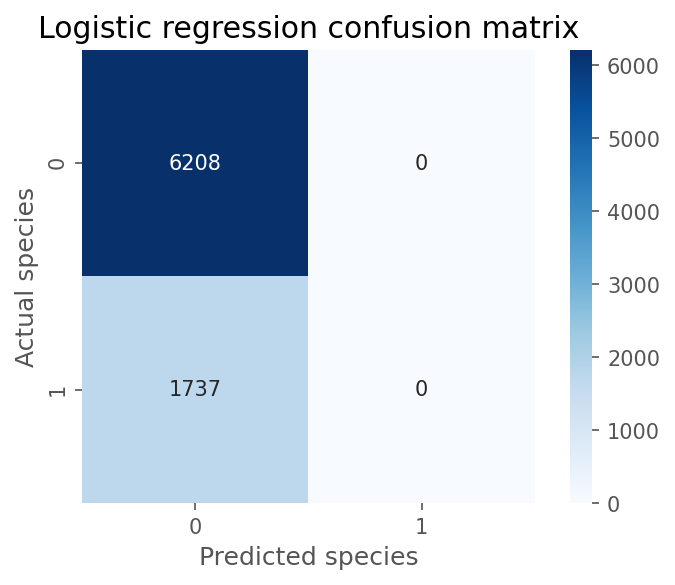

In [26]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(label_test, logit.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Logistic regression confusion matrix');

In [27]:
# Look at the logistic regression model coefficients
logit.coef_

array([[ 0.15058904,  0.49876294,  0.1716182 ,  0.3619109 , -0.01431394,
        -0.36182452,  0.55612991,  0.66549544,  0.46731668,  0.31536959,
         0.24272953,  0.42152552,  0.22795097,  0.39782822,  0.44563901,
         0.39365882,  0.8895358 ,  0.34606687,  0.23711716,  0.45213424,
         0.006294  ,  0.43307573,  0.06449384, -0.19662704, -0.04057468,
         0.02180752, -0.07083629,  0.140811  ]])

Before we move on to a different model, let's try to improve the current models by using random oversampling. We can see that there is a class imbalance in our target variable, so it's always going to be about as accurate as the imbalance itself. In other words, there are 31019 records classifying when a patient is not readmitted to the hospital and just 8706 when a patient is readmitted. That means 72% of the patients in our data aren't readmitted, so a classification model that predicts guesses "not readmitted" 72% of the time will be fairly accurate.

In [160]:
df['readmitted'].value_counts()

0    31019
1     8706
Name: readmitted, dtype: int64

In [162]:
# Add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train_combined, label_train)

In [166]:
# Yay, balanced classes!
Counter(y_resampled)

Counter({1: 23223, 0: 23223})

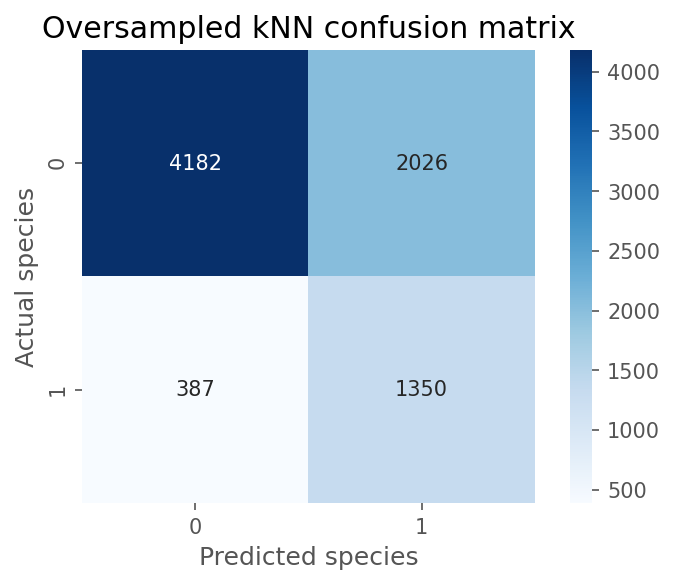

In [180]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
knn_resampled = KNeighborsClassifier()
clf_ros = knn_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
knn_resampled_confusion = confusion_matrix(label_test, knn_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(knn_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled kNN confusion matrix');

In [178]:
print_accuracy(knn_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for KNeighborsClassifier() is...
Training:  81.91%
Test set:  69.63%


In [179]:
precision_and_recall(label_test, knn_resampled.predict(X_test_combined))

Default threshold...
Precision:  39.99%, Recall:  77.72%


We'll try the same thing for the logistic regression model.

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


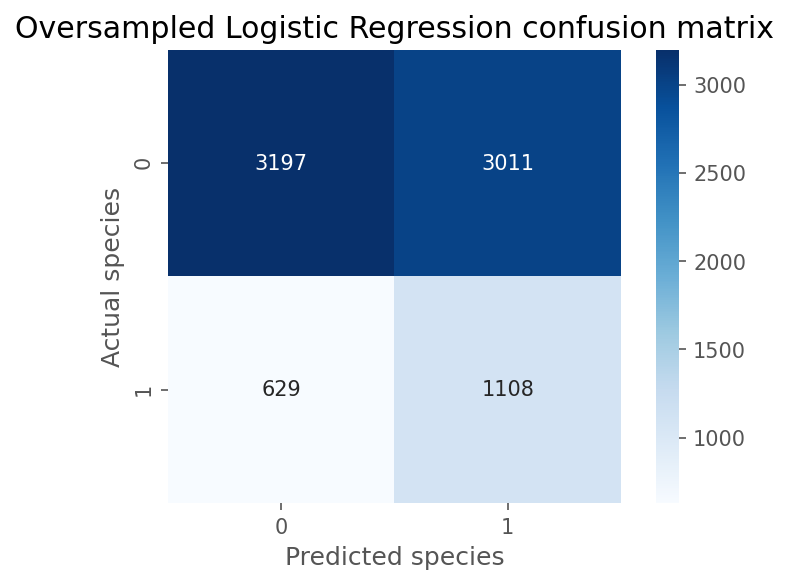

In [184]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
lr_resampled = LogisticRegression()
clf_ros = lr_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
lr_resampled_confusion = confusion_matrix(label_test, lr_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(lr_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Logistic Regression confusion matrix');

In [182]:
print_accuracy(lr_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for LogisticRegression() is...
Training:  56.87%
Test set:  54.19%


In [183]:
precision_and_recall(label_test, lr_resampled.predict(X_test_combined))

Default threshold...
Precision:  26.90%, Recall:  63.79%


### Decision Tree and Random Forest

In [28]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [29]:
def visualize(X, y, bdry='diag'):
    c = cm.rainbow(np.linspace(0, 1, 2))
    plt.scatter([i[0] for i in X], [i[1] for i in X], color=[c[i] for i in y], alpha=.5)
    
    #Plot the true decision boundary
    if bdry == 'diag':
        plt.plot([0, 1], [0, 1], 'k--')
    elif bdry == 'quadrant':
        plt.plot([0, 1], [0.5, 0.5], 'k--')
        plt.plot([0.5, 0.5], [0, 1], 'k--')
        
    plt.grid(True)

In [31]:
decisiontree = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times(decisiontree, X_train_combined, label_train)

0.7792906690534795

In [32]:
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train_combined, label_train)

0.7517117923472811

In [34]:
decisiontree = decisiontree.fit(X_train_combined, label_train)

label_pred = decisiontree.predict(X_test_combined)

print("Accuracy: {:6.2f}%".format(100*metrics.accuracy_score(label_test, label_pred)))

#grid = np.mgrid[0:1.02:0.02, 0:1.02:0.02].reshape(2,-1).T
#visualize(grid, decisiontree.predict(X_train_combined))

Accuracy:  78.14%


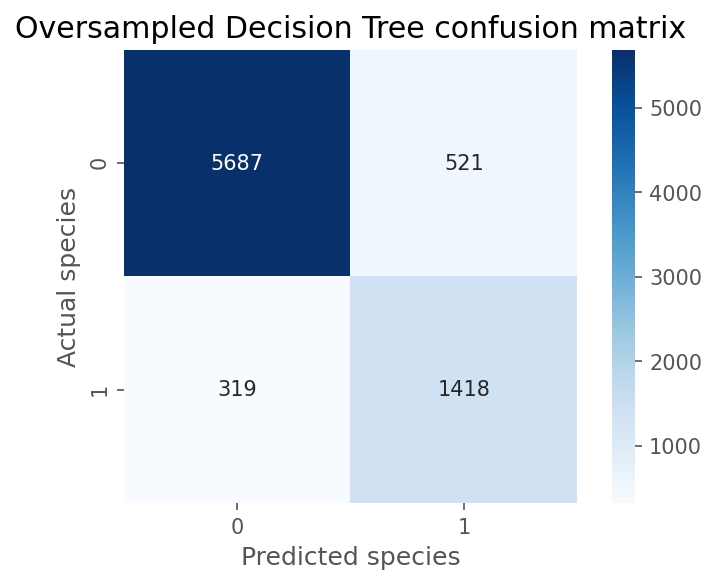

In [185]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
dt_resampled = DecisionTreeClassifier()
clf_ros = dt_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
dt_resampled_confusion = confusion_matrix(label_test, dt_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(dt_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Decision Tree confusion matrix');

In [186]:
print_accuracy(dt_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for DecisionTreeClassifier() is...
Training:  98.18%
Test set:  89.43%


In [187]:
precision_and_recall(label_test, dt_resampled.predict(X_test_combined))

Default threshold...
Precision:  73.13%, Recall:  81.64%


[Text(279.0, 489.24, 'X[1] <= 0.5\ngini = 0.344\nsamples = 29793\nvalue = [23223, 6570]'),
 Text(139.5, 380.52000000000004, 'X[27] <= -0.561\ngini = 0.273\nsamples = 6158\nvalue = [5152, 1006]'),
 Text(69.75, 271.8, 'X[7] <= 0.5\ngini = 0.22\nsamples = 2191\nvalue = [1916, 275]'),
 Text(34.875, 163.08000000000004, 'X[23] <= -0.282\ngini = 0.215\nsamples = 2157\nvalue = [1893, 264]'),
 Text(17.4375, 54.360000000000014, 'gini = 0.24\nsamples = 1340\nvalue = [1153, 187]'),
 Text(52.3125, 54.360000000000014, 'gini = 0.171\nsamples = 817\nvalue = [740, 77]'),
 Text(104.625, 163.08000000000004, 'X[22] <= -0.439\ngini = 0.438\nsamples = 34\nvalue = [23, 11]'),
 Text(87.1875, 54.360000000000014, 'gini = 0.291\nsamples = 17\nvalue = [14, 3]'),
 Text(122.0625, 54.360000000000014, 'gini = 0.498\nsamples = 17\nvalue = [9, 8]'),
 Text(209.25, 271.8, 'X[26] <= -0.48\ngini = 0.301\nsamples = 3967\nvalue = [3236, 731]'),
 Text(174.375, 163.08000000000004, 'X[23] <= 0.636\ngini = 0.357\nsamples = 1451\

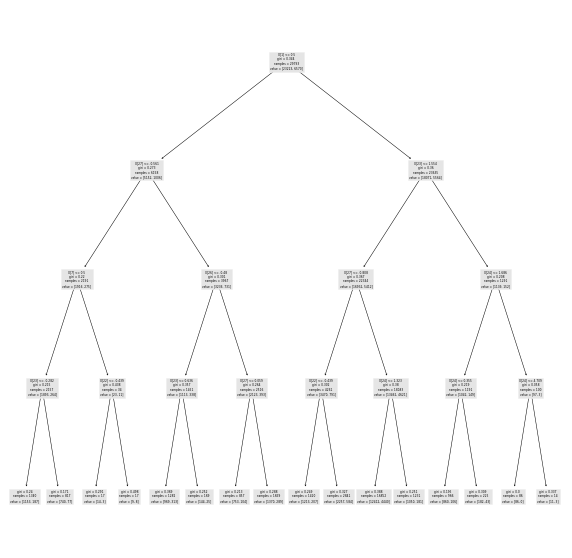

In [100]:
from sklearn import tree

plt.figure(figsize=(10, 10))
tree.plot_tree(decisiontree)

In [36]:
randomforest = randomforest.fit(X_train_combined, label_train)

label_pred = randomforest.predict(X_test_combined)

print("Accuracy: {:6.2f}%".format(100*metrics.accuracy_score(label_test, label_pred)))

Accuracy:  92.46%


/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


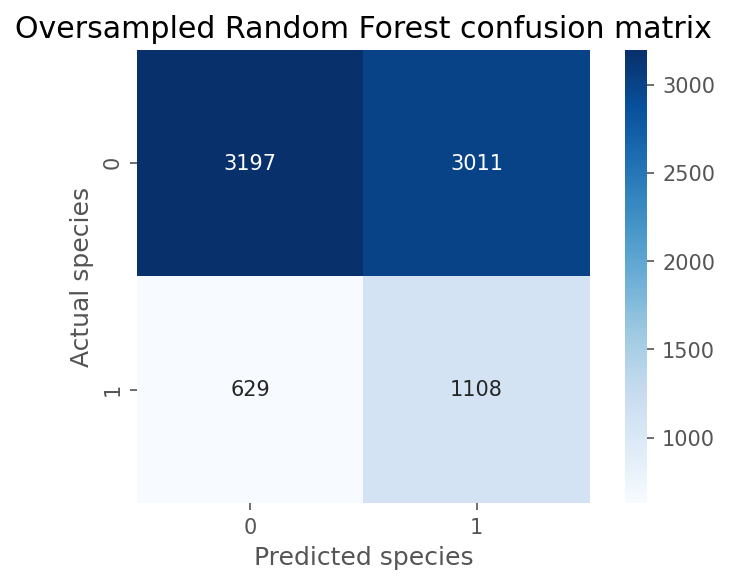

In [188]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
rf_resampled = LogisticRegression()
clf_ros = rf_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
rf_resampled_confusion = confusion_matrix(label_test, rf_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(rf_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Random Forest confusion matrix');

In [189]:
print_accuracy(rf_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for LogisticRegression() is...
Training:  56.87%
Test set:  54.19%


In [190]:
precision_and_recall(label_test, rf_resampled.predict(X_test_combined))

Default threshold...
Precision:  26.90%, Recall:  63.79%


### XGBoost

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [39]:
def rmse(actuals, preds):
    '''
    Function to calculate Root Mean Squared Error
    '''
    return np.sqrt(((actuals - preds) ** 2).mean())

Evaluate the RMSE of various models used.

In [40]:
lr = LinearRegression()
lr.fit(X_train_combined, label_train)
rmse(lr.predict(X_test_combined), label_test)

0.4091608405183042

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_combined, label_train)
rmse(knn.predict(X_test_combined), label_test)

0.453224236925209

In [42]:
rf = RandomForestRegressor(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_train_combined, label_train)
rmse(rf.predict(X_test_combined), label_test)

0.26705546125739377

In [43]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train_combined, label_train),(X_val_combined , label_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train_combined, label_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:0.48438	validation_1-rmse:0.48405
[1]	validation_0-rmse:0.47133	validation_1-rmse:0.47073
[2]	validation_0-rmse:0.46046	validation_1-rmse:0.45960
[3]	validation_0-rmse:0.45149	validation_1-rmse:0.45040
[4]	validation_0-rmse:0.44381	validation_1-rmse:0.44250
[5]	validation_0-rmse:0.43743	validation_1-rmse:0.43591
[6]	validation_0-rmse:0.43233	validation_1-rmse:0.43064
[7]	validation_0-rmse:0.42799	validation_1-rmse:0.42613
[8]	validation_0-rmse:0.42443	validation_1-rmse:0.42243
[9]	validation_0-rmse:0.42144	validation_1-rmse:0.41932
[10]	validation_0-rmse:0.41911	validation_1-rmse:0.41691
[11]	validation_0-rmse:0.41713	validation_1-rmse:0.41485
[12]	validation_0-rmse:0.41545	validation_1-rmse:0.41307
[13]	validation_0-rmse:0.41410	validation_1-rmse:0.41163
[14]	validation_0-rmse:0.41295	validation_1-rmse:0.41042
[15]	validation_0-rmse:0.41201	validation_1-rmse:0.40941
[16]	validation_0-rmse:0.41121	validation_1-rmse:0.40858
[17]	validation_0-rmse:0.41058	validation

In [44]:
# predict using n_estimators with lowest validation error
rmse(gbm.predict(X_test_combined, ntree_limit=gbm.best_ntree_limit), label_test)

0.40343141200665994

In [45]:
rmse(gbm.predict(X_val_combined, ntree_limit=gbm.best_ntree_limit), label_val)

0.40366716959067445

In [46]:
#Step by step RMSEs, with .1 learning rate:
#best max_depth: 7, .452
#best subsample: .8, .448
#best min_child_weight: 12, .446
#best colsample_bytree: .7, .444

gbm = xgb.XGBRegressor(
    n_estimators=30000,  #arbitrary large number
    max_depth=7,
    objective="reg:squarederror",
    learning_rate=.05,
    subsample=.8,
    min_child_weight=8,
    colsample_bytree=.7,
    n_jobs=-1,
    random_state=0)

eval_set = [(X_train_combined, label_train),
            (X_val_combined, label_val)]  #tracking train/validation error as we go

fit_model = gbm.fit(
    X_train_combined,
    label_train,
    eval_set=eval_set,
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=False)

rmse(gbm.predict(X_val_combined, ntree_limit=gbm.best_ntree_limit), label_val)

0.4037434974119222

In [47]:
rmse(gbm.predict(X_test_combined, ntree_limit=gbm.best_ntree_limit), label_test)

0.3965099992109256

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

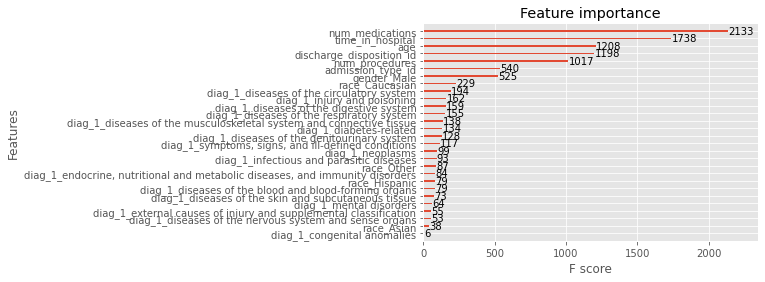

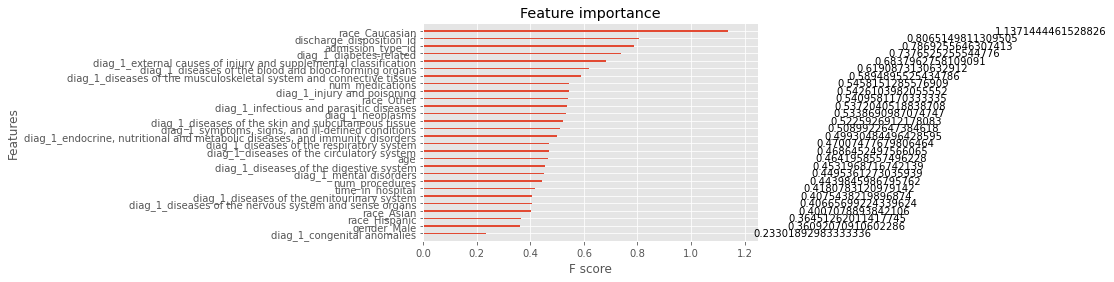

In [48]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


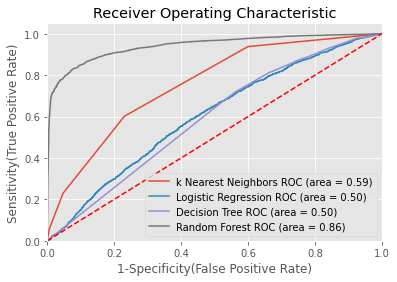

In [155]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'k Nearest Neighbors',
    'model': KNeighborsClassifier(n_neighbors=5),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(C=0.95),
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(max_depth=4),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=100),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_combined, label_train) # train the model
    y_pred = model.predict(X_test_combined) # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(label_test, model.predict_proba(X_test_combined)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(label_test, model.predict(X_test_combined))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


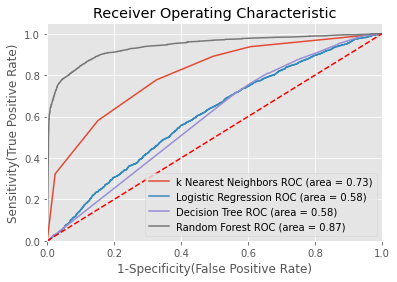

In [191]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'k Nearest Neighbors',
    'model': KNeighborsClassifier(n_neighbors=5),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(C=0.95),
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(max_depth=4),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=100),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_resampled, y_resampled) # train the model
    y_pred = model.predict(X_test_combined) # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(label_test, model.predict_proba(X_test_combined)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(label_test, model.predict(X_test_combined))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display